### Introduction
The following code used statistical methods to analyze the data and visualize features for failed and succeeded oligonucleotides. Next, I used machine learning method to figure out the key features that is related to the failure of the syntheses.

First, let's import python modules including csv, numpy and pandas used for this project.

In [1]:
import csv as csv
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Import the training dataset and get intuitive quantities.

In [2]:
# use pandas to read in csv file; always use header = 0 when you know row 0 is the header row
train = pd.read_csv('base_data.csv', header = 0)

In [3]:
# take a look at the real data
train.head(10)

,rec,length,mfe,unpaired,paired,unpairedGC,pairedGC,stack,hairpin,interior_loop,bulge,multi_loop,external,success
0,f0,562,-174.500000,208,354,77,216,177,72,73,13,47,3,0
1,f1,528,-158.399994,194,334,75,186,167,70,38,12,51,23,0
2,f2,529,-176.399994,207,322,83,185,161,95,46,20,36,10,0
3,f3,664,-197.300003,246,418,83,245,209,77,77,19,65,8,0
4,f4,722,-189.300003,308,414,98,240,207,71,115,27,65,30,0
5,f5,795,-217.000000,323,472,117,252,236,104,115,13,86,5,0
6,f6,732,-270.500000,248,484,106,301,242,51,104,26,56,11,0
7,f7,613,-147.100006,237,376,68,190,188,66,77,28,60,6,0
8,f8,729,-185.500000,357,372,121,227,186,115,90,28,109,15,0
9,f9,612,-250.500000,202,410,82,287,205,52,80,30,35,5,0


In [4]:
# let's check data properties
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880 entries, 0 to 2879
Data columns (total 14 columns):
rec              2880 non-null object
length           2880 non-null int64
mfe              2880 non-null float64
unpaired         2880 non-null int64
paired           2880 non-null int64
unpairedGC       2880 non-null int64
pairedGC         2880 non-null int64
stack            2880 non-null int64
hairpin          2880 non-null int64
interior_loop    2880 non-null int64
bulge            2880 non-null int64
multi_loop       2880 non-null int64
external         2880 non-null int64
success          2880 non-null int64
dtypes: float64(1), int64(12), object(1)
memory usage: 315.1+ KB


We can get the following information from the above analysis:
- all features are numerical
- length = unpaired + paired
- there's no missing data

Given that all features are numerical, let's get some quantitative intution of the features.

In [5]:
train.describe()

,length,mfe,unpaired,paired,unpairedGC,pairedGC,stack,hairpin,interior_loop,bulge,multi_loop,external,success
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000
mean,643.337500,-200.036924,250.200000,393.137500,94.911458,225.954167,196.568750,73.482986,79.383333,21.220833,63.625347,12.487500,0.824653
std,88.746396,56.971109,42.849895,64.566574,21.096698,57.321625,32.283287,19.106720,26.414777,9.670816,28.119793,8.403376,0.380330
min,331.000000,-519.299988,123.000000,124.000000,37.000000,73.000000,62.000000,13.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,569.000000,-234.399994,220.000000,344.000000,81.000000,186.000000,172.000000,60.000000,61.000000,14.750000,46.000000,6.000000,1.000000
50%,643.000000,-189.000000,245.000000,388.000000,91.000000,215.000000,194.000000,73.000000,77.000000,20.000000,59.000000,11.000000,1.000000
75%,710.000000,-161.000000,278.000000,440.000000,105.000000,263.000000,220.000000,85.000000,94.000000,27.000000,77.000000,17.000000,1.000000
max,964.000000,-45.000000,443.000000,684.000000,202.000000,498.000000,342.000000,154.000000,195.000000,66.000000,279.000000,69.000000,1.000000


These information can be drawn from the above analysis:
- All oligonucleotides have paired, unpaired, unpairedGC, paired GC, stack, haripin, interior_loop.
- Some oligonucleotides have no bulge, multi_Loop, external. These three features may be deal breaker?

Let's check the quantity of succeeded and failed oligonucleotides. 0 means failed and 1 means succeeded.

In [6]:
train.groupby('success').size()

success
0     505
1    2375
dtype: int64

17.5% failed and 82.5% succeeded.

### Statistic Analysis
Let's take a look at the distribution of these quantities.

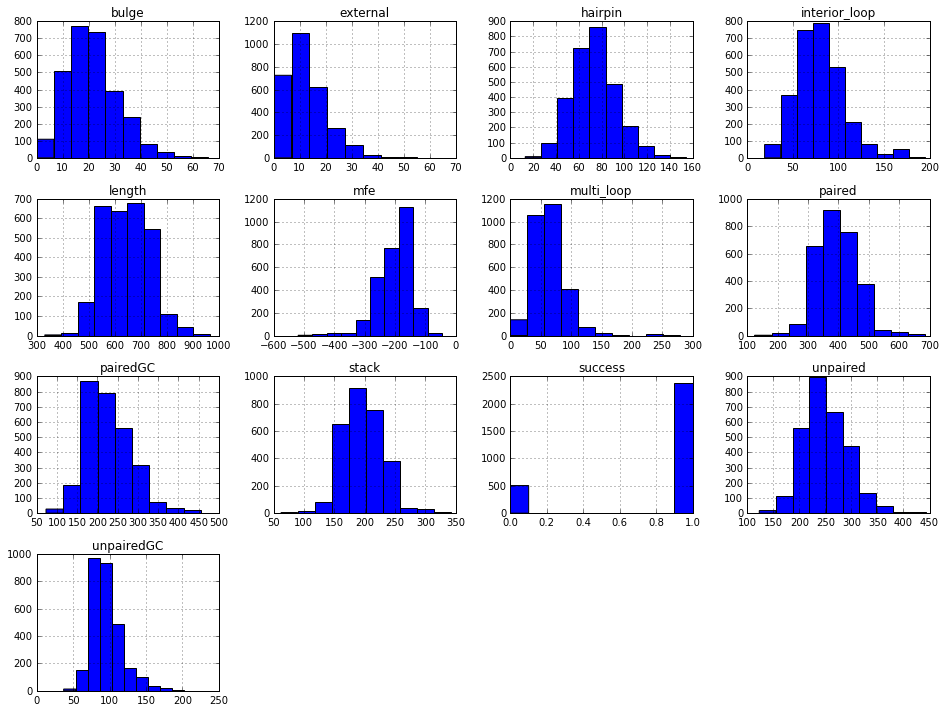

In [7]:
train.hist(figsize = (16, 12)) # default bin size = 10
plt.show()

All data follows quasi-normal distribution except 'success', which is normal.
Let's check the distribution of features for data with success = 0 and success = 1.

Let's first define a plotting function.

In [8]:
def plot_var(name, minval, maxval, yscale):
    plt.hist(train.loc[train.success == 1, name], bins = 50, color = 'b', log = yscale, label = 'Succeed, 1')
    plt.hist(train.loc[train.success == 0, name], bins = 50, color = 'r', log = yscale, label = 'Fail, 0')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

Let' plot the first seven features. log scale is easier to visualize the two ends of the histograms.

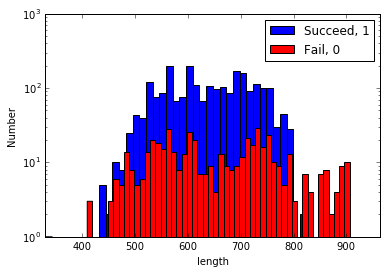

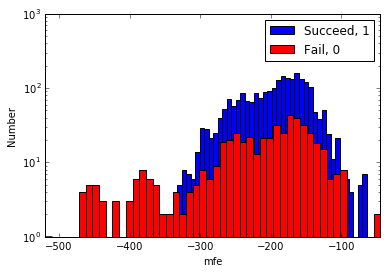

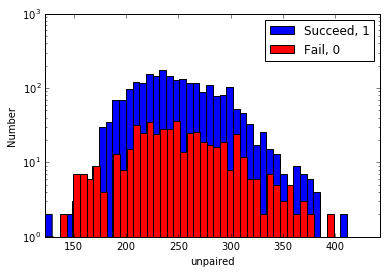

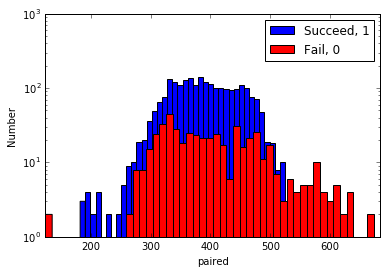

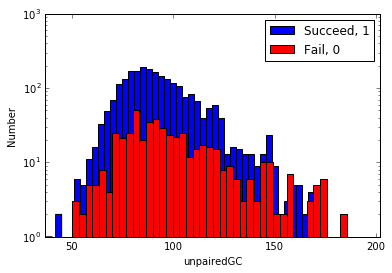

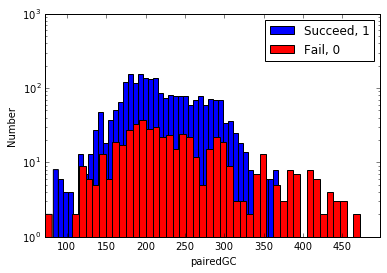

In [9]:
plot_var('length', train.length.min(), train.length.max(), True)
plot_var('mfe', train.mfe.min(), train.mfe.max(), True)
plot_var('unpaired', train.unpaired.min(), train.unpaired.max(), True)
plot_var('paired', train.paired.min(), train.paired.max(), True)
plot_var('unpairedGC', train.unpairedGC.min(), train.unpairedGC.max(), True)
plot_var('pairedGC', train.pairedGC.min(), train.pairedGC.max(), True)

Summary from above analysis:
- Too long oligonucleotides are more likely to fail. All oligonucleotides with length > 820 failed.
- Oligonucleotides with too small minimum free energy are more likely to fail. All oligonucleotides with mfe < -340 failed.
- Oligonucleotides with too many or too few paired group are more likely to fail. All oligonucleotides with paired > 520 and < 100 failed.
- Oligonucleotides with too many paired GC group are more likely to fail. All oligonucleotides with paired > 370 failed. 

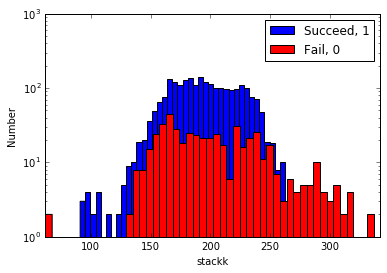

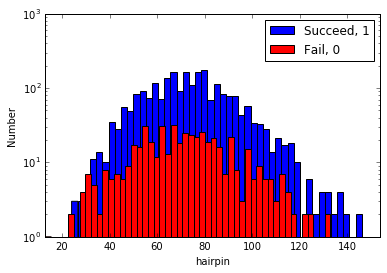

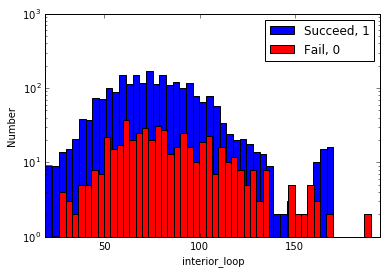

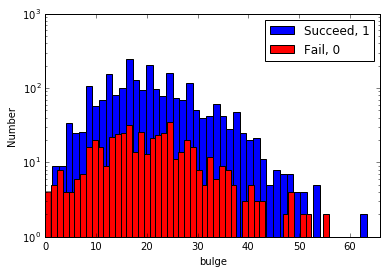

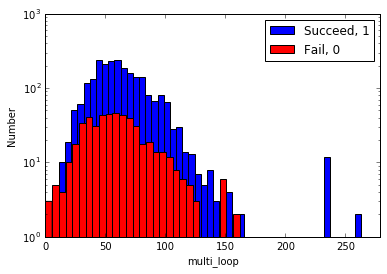

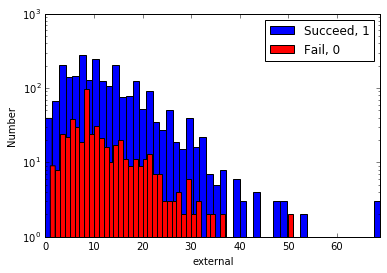

In [10]:
# stack is a function name, so we change it to avoid confusion
train['stackk'] = train['stack']

plot_var('stackk', train.stackk.min(), train.stackk.max(), True)
plot_var('hairpin', train.hairpin.min(), train.hairpin.max(), True)
plot_var('interior_loop', train.interior_loop.min(), train.interior_loop.max(), True)
plot_var('bulge', train.bulge.min(), train.bulge.max(), True)
plot_var('multi_loop', train.multi_loop.min(), train.multi_loop.max(), True)
plot_var('external', train.external.min(), train.external.max(), True)

Summary from above analysis:
    
- Oligonucleotides with too many stacks are more likely to fail. All oligonucleotides with number of stacks > 270 failed.

### Feature Engineering and Normalization

Let's delete some redudant features and add some new features to make the data more meaningful.

- paired = stack * 2, so these two features are linearly correlated, let's detete stack
- length = paired + unpaired, so these three features are also highly correlated, so let's delete unpaired for simplicity.
- GC content may be quite useful, so let's add a new column named GC = unpairedGC + pairedGC' and delete unpaired GC for simplicity.
- mfe depends on the length of the oligonucleotide, therefore normalize it using length is more fair for comparison.
- Similarly, all other features may be more useful for comparision when normalized.

In [11]:
train['GC'] = train['unpairedGC'] + train['pairedGC']
train['GC_norm'] = train['GC']/train['length']
train['mfe_norm'] = train['mfe']/train['length']
train['paired_norm'] = train['paired']/train['length']
train['pairedGC_norm'] = train['pairedGC']/train['length']
train['hairpin_norm'] = train['hairpin']/train['length']
train['interior_loop'] = train['interior_loop']/train['length']
train['bulge_norm'] = train['bulge']/train['length']
train['multi_loop_norm'] = train['multi_loop']/train['length']
train['external_norm'] = train['external']/train['length']
Y = train['success']
train = train.drop(['rec','mfe', 'stack', 'stackk', 'unpaired', 'unpairedGC', 'hairpin', 'interior_loop', 'bulge', 'multi_loop',
                    'external', 'GC', 'paired', 'pairedGC', 'success'], axis=1)

Let's also normalize length using its maximum value to complete feature normalization.

In [15]:
maxlength = train['length'].max()
train['length'] = train['length']/maxlength

In [16]:
train.head(10)

,length,GC_norm,mfe_norm,paired_norm,pairedGC_norm,hairpin_norm,bulge_norm,multi_loop_norm,external_norm
0,0.582988,0.521352,-0.310498,0.629893,0.384342,0.128114,0.023132,0.083630,0.005338
1,0.547718,0.494318,-0.300000,0.632576,0.352273,0.132576,0.022727,0.096591,0.043561
2,0.548755,0.506616,-0.333459,0.608696,0.349716,0.179584,0.037807,0.068053,0.018904
3,0.688797,0.493976,-0.297139,0.629518,0.368976,0.115964,0.028614,0.097892,0.012048
4,0.748963,0.468144,-0.262188,0.573407,0.332410,0.098338,0.037396,0.090028,0.041551
5,0.824689,0.464151,-0.272956,0.593711,0.316981,0.130818,0.016352,0.108176,0.006289
6,0.759336,0.556011,-0.369536,0.661202,0.411202,0.069672,0.035519,0.076503,0.015027
7,0.635892,0.420881,-0.239967,0.613377,0.309951,0.107667,0.045677,0.097879,0.009788
8,0.756224,0.477366,-0.254458,0.510288,0.311385,0.157750,0.038409,0.149520,0.020576
9,0.634855,0.602941,-0.409314,0.669935,0.468954,0.084967,0.049020,0.057190,0.008170


### Correlation between features

Let's first create a scatter plot matrix so that we can visualize the relationship between features.

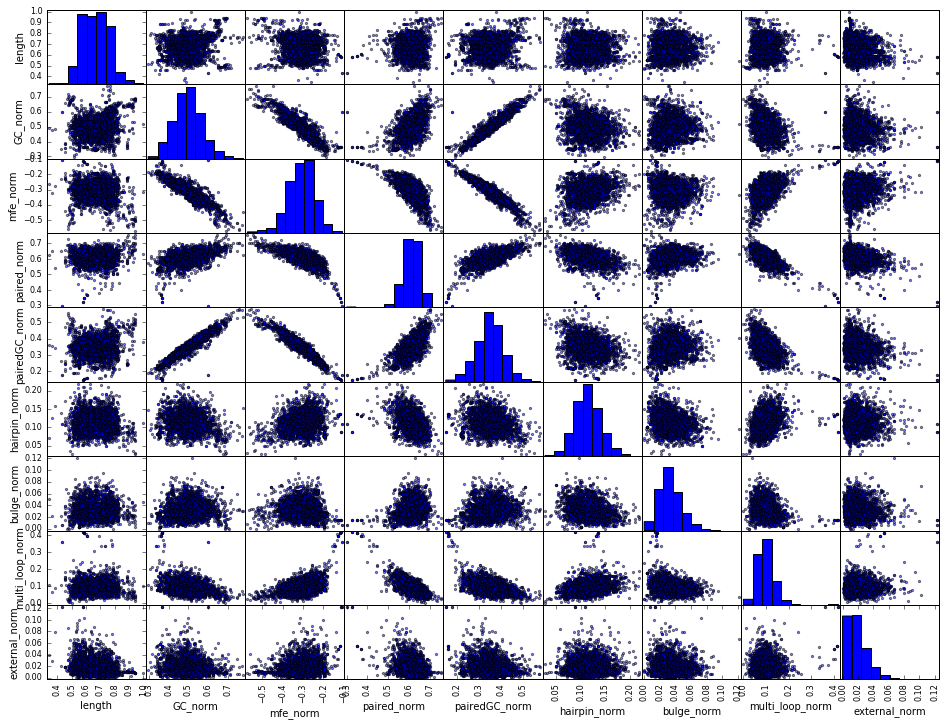

In [17]:
# multivariate plots -- scatter plot matrix
scatter_matrix(train, figsize = (16, 12))
plt.show()

The above scattering plots gave us visual correlation of different features.

Next, let's plot the correlation matrix to get quantitative correlation between different features.

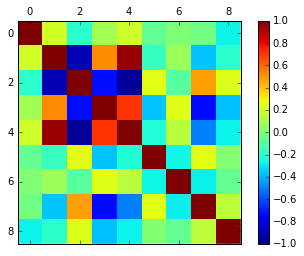

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111) 
cax = ax.matshow(train.corr(), vmin = -1, vmax = 1, interpolation = 'none')
fig.colorbar(cax)
plt.show()

Below is summary about the correlation of different features from the above correlation graph. 

Strong positively correlated features:
- 1,3 GC_norm, paired_norm
- 1,4 GC_norm, pairedGC_norm
- 2,7 mfe_norm, multi_loop_norm
- 3,4 paired_norm, pairedGC_norm

Strong negatively correlated features:
- 1,2 GC_norm, mfe_norm
- 2,3 mfe_norm, paired_norm
- 2,4 mfe_norm, pairedGC_norm
- 3,7 paired_norm, multi_loop_norm
- 4,7 pairedGC_norm, multi_loop_norm

### Summary

- The dataset contains characteristic information about 2880 oligonucleotide, of which 17.5% failed and 82.5% succeeded in the syntheses.
- Too long oligonucleotides (> 820), oligonucleotides with too small minimum free energy, too many or too few paired groups, too many 
paired GC groups are more likely to fail. These features are likely to be responsible for the failed syntheses.
- Some of these features are highly correlated, which is worth keeping in mind for future machine learning work.
